In [1]:
import pandas as pd
import numpy as np
import rioxarray
import json, os

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
seed = 42
verbose = False
details = False

In [3]:
INVASIVE_BIRDS_PATH = 'Datasets/Machine Learning/5km Rasters/Birds'
# Use this if using coordinates as separate columns
# df_5km = pd.read_csv('Datasets/Machine Learning/Dataframes/5km_All_Birds_DF.csv')

# Use this if using coordinates as indices
df_5km = pd.read_csv('Datasets/Machine Learning/Dataframes/5km_All_Birds_DF.csv', index_col=[0,1])

total_birds = (df_5km['Occurrence']==1).sum()
df_dicts = []

for file in os.listdir(INVASIVE_BIRDS_PATH):
    filename = os.fsdecode(file)
    if not filename.endswith('.tif') or filename.endswith('All_Invasive_Birds_5km.tif') :
         continue



    bird_name = filename[:-4].replace('_', ' ')

    bird_dataset = rioxarray.open_rasterio(f'{INVASIVE_BIRDS_PATH}/{file}')
    bird_dataset.name = 'data'
    bird_df = bird_dataset.squeeze().drop("spatial_ref").drop("band").to_dataframe()

    # Check if index matches
    if not df_5km.index.equals(bird_df.index):
        print('Warning: Index does not match')
        continue

    bird_df['Occurrence'] = [0 if x == -1 else 1 for x in bird_df['data']]
    bird_df = df_5km.drop(columns='Occurrence').join(bird_df.drop(columns='data'))
    
    bird_dict = {'name' : bird_name, 'dataframe' : bird_df }
    df_dicts.append(bird_dict)
    display(bird_df.sample(5))


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
712500.0,267500.0,0,0,0,0,0,0,99,0,0,0,...,1.798783e+01,1.979030e+01,1.630712e+01,3.329318e+00,8.434404e+00,2.052438e+01,7.809389e+00,1.718280e+01,8.873806e+00,0
912500.0,617500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
952500.0,7500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
202500.0,322500.0,0,20,0,0,0,0,67,0,0,5,...,1.277848e+00,3.201799e-02,9.166379e-01,-3.400000e+38,3.987500e-01,-3.400000e+38,4.136672e+00,2.444737e+00,2.649246e+01,0
1237500.0,447500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
982500.0,692500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
482500.0,77500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
57500.0,677500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
627500.0,662500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
602500.0,657500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
132500.0,607500.0,0,0,99,0,0,0,0,1,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
367500.0,177500.0,0,0,0,0,0,0,0,0,0,0,...,5.604231e-01,1.088421e-01,4.968090e-01,2.101036e+00,3.069444e-01,1.085213e+00,1.441999e+00,5.178424e-01,-3.400000e+38,0
677500.0,107500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
937500.0,577500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
847500.0,127500.0,0,0,0,21,0,0,0,0,0,11,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
437500.0,172500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
897500.0,432500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
942500.0,267500.0,0,32,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1162500.0,327500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
852500.0,7500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
847500.0,617500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
32500.0,452500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
852500.0,52500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
432500.0,647500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
587500.0,602500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1192500.0,62500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
667500.0,492500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
337500.0,37500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1142500.0,162500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
297500.0,232500.0,0,0,0,0,0,0,0,0,0,0,...,4.729528e-03,1.255404e-03,4.127780e-03,-3.400000e+38,2.866850e-03,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
307500.0,42500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
622500.0,97500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1212500.0,462500.0,0,0,0,95,4,0,0,0,0,1,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
962500.0,102500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
702500.0,617500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
157500.0,317500.0,0,0,0,0,0,0,0,0,0,0,...,1.039940e+00,9.736983e-01,4.649050e-01,1.416382e+01,5.824835e-01,7.660726e+00,1.317793e+01,4.763658e-01,2.666079e+00,0
102500.0,497500.0,0,0,60,20,0,0,0,0,0,0,...,2.453516e-01,2.766496e-02,9.993535e-02,-3.400000e+38,8.190275e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,1.525854e+00,0
982500.0,657500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
277500.0,357500.0,18,0,24,56,0,0,0,0,0,0,...,3.466839e-01,8.026547e-02,2.348484e-01,6.775991e+00,1.820343e-01,3.088803e+00,1.260376e+01,9.621822e+00,3.166261e-01,0
837500.0,442500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
382500.0,287500.0,0,0,0,0,0,0,0,0,0,0,...,2.014876e+01,1.258746e+01,8.709696e+00,1.525128e+00,1.512782e+01,8.309065e-01,1.292195e+00,1.240951e-01,-3.400000e+38,0
872500.0,532500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
207500.0,277500.0,1,24,0,0,0,0,75,0,0,0,...,1.179403e+01,5.411642e+00,3.950109e+00,-3.400000e+38,1.388328e+01,-3.400000e+38,-3.400000e+38,-3.400000e+38,1.120048e+00,0
492500.0,552500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1227500.0,597500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
572500.0,297500.0,0,0,14,39,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
517500.0,322500.0,0,0,0,3,0,0,92,0,5,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1012500.0,412500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
997500.0,172500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1037500.0,432500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
572500.0,497500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
492500.0,57500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,1
922500.0,567500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
47500.0,697500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1127500.0,387500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1042500.0,317500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1137500.0,27500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
412500.0,372500.0,16,0,0,18,7,0,0,0,0,0,...,4.812847e-01,3.832059e-01,1.223652e-01,9.612413e+00,6.272641e-01,1.787285e+01,3.912202e+01,8.795641e+00,8.603662e+00,1
327500.0,302500.0,0,6,0,0,0,0,87,0,7,0,...,1.069695e+01,2.152610e+01,3.006510e+00,6.767461e-01,1.180971e+01,3.648056e-01,1.054585e+00,6.870680e-01,6.149307e-01,0
297500.0,187500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
682500.0,607500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
382500.0,507500.0,21,0,78,1,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
92500.0,322500.0,14,3,0,83,0,0,0,0,0,0,...,3.587797e+01,4.035234e+00,6.205773e+00,-3.400000e+38,1.283332e+01,-3.400000e+38,2.534976e+00,1.620783e+00,6.527980e+00,0
687500.0,352500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
832500.0,602500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
187500.0,352500.0,0,0,0,0,0,0,0,0,0,0,...,1.477417e+01,2.679824e-01,1.659697e+00,-3.400000e+38,8.258803e+00,-3.400000e+38,1.503984e+01,8.817699e+00,1.427644e+01,0
802500.0,77500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
297500.0,202500.0,0,0,0,0,0,0,0,0,0,0,...,2.849020e-01,6.871427e-02,2.899346e-01,-3.400000e+38,1.796557e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
887500.0,627500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
347500.0,322500.0,15,5,0,21,0,0,31,0,23,0,...,1.635319e-01,4.662686e-02,1.295188e-01,-3.400000e+38,7.957139e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
172500.0,362500.0,14,0,0,0,0,0,0,0,0,0,...,3.912434e+01,3.640354e+00,5.398479e+00,-3.400000e+38,1.433207e+01,-3.400000e+38,2.191259e+01,1.031152e+01,1.028668e+00,0
542500.0,552500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1202500.0,72500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
182500.0,567500.0,0,0,53,18,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
777500.0,162500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
402500.0,597500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
407500.0,222500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
47500.0,337500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1167500.0,492500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
292500.0,562500.0,0,0,100,0,0,0,0,0,0,0,...,2.675856e+01,8.376548e+00,3.281430e+00,-3.400000e+38,1.165780e+01,-3.400000e+38,4.417632e+00,3.699409e+00,5.309461e+00,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1097500.0,367500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
472500.0,367500.0,6,0,3,89,0,0,0,0,0,0,...,1.437559e+01,3.220966e+00,2.944471e+00,1.022916e+00,1.498519e+01,6.039355e-01,1.314591e+00,2.093061e-01,1.596312e+01,0
782500.0,547500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
842500.0,327500.0,11,8,7,59,0,0,10,0,0,0,...,1.968980e+00,1.555213e-01,2.060352e+00,3.130774e+00,9.114452e-01,1.572151e+00,5.525377e-01,3.950021e+00,1.179231e+01,0
1062500.0,202500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
272500.0,142500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
457500.0,532500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
792500.0,272500.0,0,0,0,0,0,0,0,0,100,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1057500.0,12500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1257500.0,562500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
182500.0,112500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
922500.0,497500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1252500.0,647500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1202500.0,62500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1127500.0,87500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
617500.0,22500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
632500.0,132500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
72500.0,282500.0,4,0,58,30,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
207500.0,222500.0,17,0,0,8,0,0,0,0,3,4,...,4.860930e-03,1.019901e-03,6.186086e-03,-3.400000e+38,2.953693e-03,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
602500.0,397500.0,4,0,26,69,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


In [4]:
# Drop Fertiliser and Pesticide
for dict in df_dicts:
    cur_df = dict["dataframe"]
    dict["dataframe"].drop(cur_df.iloc[:, 26:-1], inplace=True, axis=1)
    display(cur_df.sample(5))

,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
957500.0,177500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
717500.0,92500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
357500.0,197500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
757500.0,27500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
792500.0,7500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1082500.0,462500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
942500.0,192500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
547500.0,292500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1237500.0,172500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
107500.0,687500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
262500.0,592500.0,6,8,78,4,0,0,0,0,0,0,...,0,0,0,5,696,21,2,8,6,0
292500.0,567500.0,1,0,32,63,0,0,0,3,0,0,...,0,0,0,1,5,2003,2,34,16,1
167500.0,562500.0,3,0,77,1,0,13,0,0,0,0,...,0,0,0,5,1019,2,2,6,1,0
67500.0,277500.0,6,7,53,33,0,0,0,0,0,0,...,0,0,0,2,1070,10,2,6,8,0
152500.0,552500.0,48,0,0,24,0,0,0,0,0,0,...,0,0,0,28,1988,10,2,8,7,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
512500.0,42500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1022500.0,217500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
737500.0,322500.0,15,0,71,13,0,0,0,0,0,0,...,0,0,0,2,738,35,2,1,20,0
1217500.0,622500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1277500.0,497500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
772500.0,437500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
597500.0,127500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1182500.0,637500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
497500.0,587500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
207500.0,42500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
577500.0,342500.0,13,3,0,85,0,0,0,0,0,0,...,0,0,0,0,883,1,2,2,0,0
137500.0,682500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
422500.0,667500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
152500.0,362500.0,0,0,32,68,0,0,0,0,0,0,...,0,0,0,0,1786,25,2,8,2,0
1287500.0,22500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1217500.0,357500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
982500.0,157500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
917500.0,227500.0,0,0,0,0,0,0,99,0,0,0,...,0,0,0,0,4460,4,2,3,32,0
712500.0,7500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
607500.0,607500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1092500.0,2500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
17500.0,422500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1242500.0,497500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
272500.0,387500.0,1,0,61,18,16,0,0,0,0,0,...,0,0,1,2,611,1,2,6,0,0
1217500.0,427500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
797500.0,542500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
557500.0,237500.0,5,0,1,88,0,0,0,0,0,0,...,0,0,0,2,300,9,2,4,148,0
967500.0,222500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
972500.0,512500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
592500.0,677500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
902500.0,487500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
457500.0,292500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
747500.0,697500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
762500.0,282500.0,0,48,0,0,0,0,1,0,39,0,...,0,0,0,0,3268,1,2,8,0,0
962500.0,552500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
52500.0,397500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1102500.0,497500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1202500.0,202500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1122500.0,297500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
857500.0,282500.0,0,0,0,0,0,0,0,0,0,0,...,11,38,0,0,35,1,2,8,0,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
617500.0,587500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1002500.0,567500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1137500.0,697500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1147500.0,262500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1177500.0,667500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1107500.0,97500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1042500.0,502500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
777500.0,627500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1012500.0,457500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
522500.0,502500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
797500.0,252500.0,0,0,0,0,0,0,0,0,100,0,...,0,0,0,0,4891,35,2,1,128,0
422500.0,127500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
52500.0,382500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
152500.0,142500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
982500.0,647500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1037500.0,652500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1117500.0,522500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
722500.0,62500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
582500.0,442500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
877500.0,32500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
302500.0,297500.0,0,3,0,0,0,0,97,0,0,0,...,0,0,0,0,3764,18,2,7,2,0
912500.0,297500.0,18,0,0,1,0,0,0,0,81,0,...,0,0,0,0,2301,3,2,1,64,0
1152500.0,472500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1042500.0,172500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
802500.0,532500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1122500.0,637500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
267500.0,242500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
172500.0,202500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
802500.0,322500.0,0,0,0,0,0,0,8,0,92,0,...,0,0,0,0,4998,4,2,3,32,0
512500.0,522500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
502500.0,397500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,5413,8,2,3,40,0
1062500.0,372500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1232500.0,82500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
2500.0,342500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1287500.0,7500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
102500.0,257500.0,30,11,0,60,0,0,0,0,0,0,...,0,0,0,0,982,202,2,9,15,0
1232500.0,332500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1182500.0,37500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
557500.0,52500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
187500.0,212500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Littoral sediment,Saltmarsh,Urban,Suburban,Elevation,Cumulative catchment area,Surface type,Outflowing drainage direction,Inflowing drainage direction,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1147500.0,547500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1027500.0,172500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
1247500.0,612500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-9999,-9999,-1,-1,255,0
62500.0,372500.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1000,-9999,0,-2,0,0
752500.0,272500.0,0,0,0,0,0,0,0,0,100,0,...,0,0,0,0,6182,4,2,7,4,0


In [5]:
# Data Cleaning
np.random.seed(seed=seed)

for dict in df_dicts:
    cur_df = dict["dataframe"]
    cur_df_name = dict["name"]

    print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
    no_occurences = cur_df[cur_df['Occurrence']==0].index 
    sample_size = sum(cur_df['Occurrence']==0) - total_birds + sum(cur_df['Occurrence']==1)
    random_indices = np.random.choice(no_occurences, sample_size, replace=False)
    dict["dataframe"] =  cur_df.drop(random_indices)
    
    print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')


# for dict in df_dicts:
#     cur_df = dict["dataframe"]
#     cur_df_name = dict["name"]

#     print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
#     no_occurences = cur_df[cur_df['Occurrence']==0].index
#     sample_size = sum(cur_df['Occurrence']==0) - sum(cur_df['Occurrence']==1)
#     random_indices = np.random.choice(no_occurences, sample_size, replace=False)
#     dict["dataframe"] =  cur_df.drop(random_indices)
    
#     print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')

Barnacle Goose 5km data before drop: 
 Occurrence
0    35813
1      587
dtype: int64 

Barnacle Goose 5km data after drop: 
 Occurrence
0    7378
1     587
dtype: int64 

Canada Goose 5km data before drop: 
 Occurrence
0    32095
1     4305
dtype: int64 

Canada Goose 5km data after drop: 
 Occurrence
1    4305
0    3660
dtype: int64 

Egyptian Goose 5km data before drop: 
 Occurrence
0    35915
1      485
dtype: int64 

Egyptian Goose 5km data after drop: 
 Occurrence
0    7480
1     485
dtype: int64 

Gadwall 5km data before drop: 
 Occurrence
0    35001
1     1399
dtype: int64 

Gadwall 5km data after drop: 
 Occurrence
0    6566
1    1399
dtype: int64 

Goshawk 5km data before drop: 
 Occurrence
0    35954
1      446
dtype: int64 

Goshawk 5km data after drop: 
 Occurrence
0    7519
1     446
dtype: int64 

Grey Partridge 5km data before drop: 
 Occurrence
0    34771
1     1629
dtype: int64 

Grey Partridge 5km data after drop: 
 Occurrence
0    6336
1    1629
dtype: int64 

Indian

In [6]:
# Standardisation
def standardise(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Add headers back
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Revert 'Surface type' back to non-standardised column as it is a categorical feature
    X_scaled_df['Surface type'] = X['Surface type'].values
    return X_scaled_df

In [7]:
# Feature Selection

# Check if any columns have NaN in them
# nan_columns = []
# for column in X_scaled_df:
#     if X_scaled_df[column].isnull().values.any():
#         nan_columns.append(column)
# print(nan_columns if len(nan_columns)!= 0 else 'None')


# Using ANOVA F-Score as a feature selection method
def feature_select(X, y):
    k_nums = [5, 10, 15, 20]
    kbest_dict = {}
    for num in k_nums:
        # Needs to be 1d array, y.values.ravel() converts y into a 1d array
        best_X = SelectKBest(f_classif, k=num).fit(X, y.values.ravel())
        # kbest_dict[str(num)] = best_X.get_feature_names_out().tolist()
        kbest_dict[str(num)] = best_X
    # kbest_dict['40'] = list(X.columns)

    best_X = SelectKBest(f_classif, k='all').fit(X, y.values.ravel())

    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = best_X.scores_
    feat_scores["P Value"] = best_X.pvalues_
    feat_scores["Attribute"] = X.columns
    kbest_dict['Dataframe'] = feat_scores.sort_values(["F Score", "P Value"], ascending=[False, False])


    if details:
        print(f'K-Best Features Dataframe: \n{kbest_dict["Dataframe"]} \n')
    # print(json.dumps(kbest_dict, indent=4))
    return kbest_dict

In [8]:
# Resample (upsample) minority data
# for dict in df_dicts:
#     if sum(dict['dataframe']['Occurence']==1) > sum(dict['dataframe']['Occurence']==0):
#         continue

# from sklearn.utils import resample

# def upsample(X, y):
#     X_1 = X[y['Occurrence'] == 1] # Getting positive occurrences (minority)
#     X_0 = X[y['Occurrence'] == 0] # Getting negative occurrences (majority)
    
#     X_1_upsampled = resample(X_1 ,random_state=seed,n_samples=total_birds/2,replace=True)


#     print(f'Resampling: \n {y.value_counts()} \n')


In [9]:
def oversample(X_train, y_train):
    over = RandomOverSampler(sampling_strategy='minority', random_state=seed)
    smote = SMOTE(random_state=seed, sampling_strategy='minority')
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    if details:
        print(f'Resampled Value Counts: \n {y_smote.value_counts()} \n')

    return X_smote, y_smote

In [10]:
All_bird_occurrences = pd.DataFrame([(dict['name'],sum(dict['dataframe']['Occurrence'] == 1)) for dict in df_dicts], columns=['Name', 'Occurrence Count'])
All_bird_occurrences['Percentage'] = All_bird_occurrences['Occurrence Count']/total_birds

All_bird_occurrences.sort_values('Occurrence Count', ascending=False)

,Name,Occurrence Count,Percentage
9,Mute Swan 5km,5267,0.661268
1,Canada Goose 5km,4305,0.540490
10,Pheasant 5km,3848,0.483114
16,Rock Dove 5km,2830,0.355304
7,Little Owl 5km,2158,0.270935
14,Red-legged Partridge 5km,2150,0.269931
19,Wigeon 5km,1857,0.233145
5,Grey Partridge 5km,1629,0.204520
3,Gadwall 5km,1399,0.175643
11,Pink-footed Goose 5km,1313,0.164846


In [11]:
# Add model pipeline
estimators = [
    ('lr', LogisticRegression(max_iter=10000, solver='saga', random_state=seed, penalty='l2', verbose=verbose)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier( max_iter=10000, loss='modified_huber', random_state=seed, penalty='l2', verbose=verbose)),
    ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=seed, verbose=verbose))
]


for dict in df_dicts:
    print(f'Training with {dict["name"]} cells... \n')
    # Use this if using coordinates as separate columns
    # coords, X, y = data['dataframe'].iloc[:, :2], data['dataframe'].iloc[:, 2:-1], data['dataframe'].iloc[:, [-1]]
    # data['coords'] = coords
    
    # Use this if using coordinates as indices
    X, y = dict['dataframe'].iloc[:, 0:-1], dict['dataframe'].iloc[:, [-1]], 

    dict['X'] = standardise(X)
    dict['y'] = y
    dict['kbest'] = feature_select(dict['X'], dict['y'])

    # dict['X'] = dict['kbest']['10'].transform(dict['X'])

    X_train, X_test, y_train, y_test = train_test_split(dict['X'], dict['y'], random_state=seed)
    dict['X_train'], dict['X_test'], dict['y_train'], dict['y_test'] = X_train, X_test, y_train, y_test # for debugging purposes

    dict['X_smote'], dict['y_smote'] = oversample(X_train, y_train)

    stack_clf = StackingClassifier(
        estimators=estimators, 
        final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=seed)
    )

    # Classifier without SMOTE
    stack_clf.fit(dict['X_train'], dict['y_train'])
    y_pred = stack_clf.predict(X_test)
    
    dict['predictions'] = y_pred
    dict['report'] = classification_report(y_test, y_pred, output_dict=True)
    

    # Classifier with SMOTE
    stack_clf.fit(dict['X_smote'], dict['y_smote'])
    y_pred_smote = stack_clf.predict(X_test)
    
    dict['predictions_smote'] = y_pred_smote
    dict['report_smote'] = classification_report(y_test, y_pred_smote, output_dict=True)
    
    print(f'{dict["name"]} Classification Report: \n {json.dumps(dict["report"], indent=4)} \n')
    print(f'{dict["name"]} SMOTE Classification Report: \n {json.dumps(dict["report_smote"], indent=4)} \n')



Training with Barnacle Goose 5km cells... 



c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Barnacle Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.934793683138054,
        "recall": 0.995119305856833,
        "f1-score": 0.9640136590491201,
        "support": 1844
    },
    "1": {
        "precision": 0.6896551724137931,
        "recall": 0.13513513513513514,
        "f1-score": 0.22598870056497178,
        "support": 148
    },
    "accuracy": 0.9312248995983936,
    "macro avg": {
        "precision": 0.8122244277759236,
        "recall": 0.5651272204959841,
        "f1-score": 0.5950011798070459,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9165805809356491,
        "recall": 0.9312248995983936,
        "f1-score": 0.9091804794027075,
        "support": 1992
    }
} 

Barnacle Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9457964601769911,
        "recall": 0.9273318872017353,
        "f1-score": 0.936473165388828,
        "support": 1844
    },
    "1": {
        "precision": 0.2717391

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Canada Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.9504830917874396,
        "recall": 0.8582333696837514,
        "f1-score": 0.9020057306590258,
        "support": 917
    },
    "1": {
        "precision": 0.8883161512027491,
        "recall": 0.9618604651162791,
        "f1-score": 0.923626619026351,
        "support": 1075
    },
    "accuracy": 0.9141566265060241,
    "macro avg": {
        "precision": 0.9193996214950944,
        "recall": 0.9100469174000152,
        "f1-score": 0.9128161748426884,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.916934165518091,
        "recall": 0.9141566265060241,
        "f1-score": 0.9136736297528384,
        "support": 1992
    }
} 

Canada Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9319492502883506,
        "recall": 0.88113413304253,
        "f1-score": 0.905829596412556,
        "support": 917
    },
    "1": {
        "precision": 0.9031111111111111

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Egyptian Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.9474768280123584,
        "recall": 0.9881847475832438,
        "f1-score": 0.9674027339642481,
        "support": 1862
    },
    "1": {
        "precision": 0.56,
        "recall": 0.2153846153846154,
        "f1-score": 0.3111111111111111,
        "support": 130
    },
    "accuracy": 0.9377510040160643,
    "macro avg": {
        "precision": 0.7537384140061792,
        "recall": 0.6017846814839296,
        "f1-score": 0.6392569225376796,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9221896856219937,
        "recall": 0.9377510040160643,
        "f1-score": 0.924572457372427,
        "support": 1992
    }
} 

Egyptian Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9553571428571429,
        "recall": 0.976906552094522,
        "f1-score": 0.9660116834838025,
        "support": 1862
    },
    "1": {
        "precision": 0.5113636363636364,
    

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Gadwall 5km Classification Report: 
 {
    "0": {
        "precision": 0.9283965728274174,
        "recall": 0.9266951740989615,
        "f1-score": 0.9275450932436564,
        "support": 1637
    },
    "1": {
        "precision": 0.664804469273743,
        "recall": 0.6704225352112676,
        "f1-score": 0.667601683029453,
        "support": 355
    },
    "accuracy": 0.8810240963855421,
    "macro avg": {
        "precision": 0.7966005210505802,
        "recall": 0.7985588546551146,
        "f1-score": 0.7975733881365548,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.881421072445111,
        "recall": 0.8810240963855421,
        "f1-score": 0.8812198369052818,
        "support": 1992
    }
} 

Gadwall 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.905727923627685,
        "recall": 0.9273060476481368,
        "f1-score": 0.9163899788711137,
        "support": 1637
    },
    "1": {
        "precision": 0.6234177215189873,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Goshawk 5km Classification Report: 
 {
    "0": {
        "precision": 0.9532994923857868,
        "recall": 0.9910290237467019,
        "f1-score": 0.9717981888745149,
        "support": 1895
    },
    "1": {
        "precision": 0.22727272727272727,
        "recall": 0.05154639175257732,
        "f1-score": 0.08403361344537814,
        "support": 97
    },
    "accuracy": 0.945281124497992,
    "macro avg": {
        "precision": 0.590286109829257,
        "recall": 0.5212877077496396,
        "f1-score": 0.5279159011599465,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9179457794259641,
        "recall": 0.945281124497992,
        "f1-score": 0.92856868896657,
        "support": 1992
    }
} 

Goshawk 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9608967674661105,
        "recall": 0.9725593667546174,
        "f1-score": 0.966692892735379,
        "support": 1895
    },
    "1": {
        "precision": 0.2972972972972973,
      

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Grey Partridge 5km Classification Report: 
 {
    "0": {
        "precision": 0.9430628272251309,
        "recall": 0.902316844082655,
        "f1-score": 0.92224,
        "support": 1597
    },
    "1": {
        "precision": 0.6637931034482759,
        "recall": 0.779746835443038,
        "f1-score": 0.7171129220023283,
        "support": 395
    },
    "accuracy": 0.8780120481927711,
    "macro avg": {
        "precision": 0.8034279653367034,
        "recall": 0.8410318397628465,
        "f1-score": 0.8196764610011642,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8876855476609453,
        "recall": 0.8780120481927711,
        "f1-score": 0.881564700899056,
        "support": 1992
    }
} 

Grey Partridge 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8988278840222085,
        "recall": 0.9123356293049468,
        "f1-score": 0.9055313859540087,
        "support": 1597
    },
    "1": {
        "precision": 0.6226415094339622,
  

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Indian Peafowl 5km Classification Report: 
 {
    "0": {
        "precision": 0.9617321248741189,
        "recall": 0.9968684759916493,
        "f1-score": 0.9789851358277807,
        "support": 1916
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 76
    },
    "accuracy": 0.9588353413654619,
    "macro avg": {
        "precision": 0.4808660624370594,
        "recall": 0.49843423799582465,
        "f1-score": 0.48949256791389034,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9250395337644637,
        "recall": 0.9588353413654619,
        "f1-score": 0.941634297312263,
        "support": 1992
    }
} 

Indian Peafowl 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9655172413793104,
        "recall": 0.9791231732776617,
        "f1-score": 0.9722726094843224,
        "support": 1916
    },
    "1": {
        "precision": 0.1836734693877551,
        "recall": 0.1184210526315

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Little Owl 5km Classification Report: 
 {
    "0": {
        "precision": 0.9757174392935982,
        "recall": 0.8941335131490222,
        "f1-score": 0.9331456720619283,
        "support": 1483
    },
    "1": {
        "precision": 0.7519747235387045,
        "recall": 0.9351669941060904,
        "f1-score": 0.8336252189141856,
        "support": 509
    },
    "accuracy": 0.9046184738955824,
    "macro avg": {
        "precision": 0.8638460814161514,
        "recall": 0.9146502536275563,
        "f1-score": 0.883385445488057,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9185462333100436,
        "recall": 0.9046184738955824,
        "f1-score": 0.9077159980397391,
        "support": 1992
    }
} 

Little Owl 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9462897526501767,
        "recall": 0.9028995279838166,
        "f1-score": 0.9240855762594893,
        "support": 1483
    },
    "1": {
        "precision": 0.750433275563258

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mandarin Duck 5km Classification Report: 
 {
    "0": {
        "precision": 0.9205194805194805,
        "recall": 0.9800884955752213,
        "f1-score": 0.9493704795070987,
        "support": 1808
    },
    "1": {
        "precision": 0.4626865671641791,
        "recall": 0.16847826086956522,
        "f1-score": 0.24701195219123506,
        "support": 184
    },
    "accuracy": 0.9051204819277109,
    "macro avg": {
        "precision": 0.6916030238418298,
        "recall": 0.5742833782223933,
        "f1-score": 0.5981912158491669,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8782296933420832,
        "recall": 0.9051204819277109,
        "f1-score": 0.8844939890321394,
        "support": 1992
    }
} 

Mandarin Duck 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9320282762370854,
        "recall": 0.9480088495575221,
        "f1-score": 0.9399506443652318,
        "support": 1808
    },
    "1": {
        "precision": 0.385620

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mute Swan 5km Classification Report: 
 {
    "0": {
        "precision": 0.9235668789808917,
        "recall": 0.8357348703170029,
        "f1-score": 0.8774583963691377,
        "support": 694
    },
    "1": {
        "precision": 0.9164222873900293,
        "recall": 0.963020030816641,
        "f1-score": 0.9391435011269722,
        "support": 1298
    },
    "accuracy": 0.9186746987951807,
    "macro avg": {
        "precision": 0.9199945831854606,
        "recall": 0.899377450566822,
        "f1-score": 0.9083009487480549,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9189114171912635,
        "recall": 0.9186746987951807,
        "f1-score": 0.9176528069994937,
        "support": 1992
    }
} 

Mute Swan 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8382749326145552,
        "recall": 0.8962536023054755,
        "f1-score": 0.8662952646239555,
        "support": 694
    },
    "1": {
        "precision": 0.9424,
        "reca

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pheasant 5km Classification Report: 
 {
    "0": {
        "precision": 0.931321540062435,
        "recall": 0.8655705996131529,
        "f1-score": 0.8972431077694236,
        "support": 1034
    },
    "1": {
        "precision": 0.8651794374393792,
        "recall": 0.9311064718162839,
        "f1-score": 0.8969331322272499,
        "support": 958
    },
    "accuracy": 0.8970883534136547,
    "macro avg": {
        "precision": 0.8982504887509071,
        "recall": 0.8983385357147184,
        "f1-score": 0.8970881199983367,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8995122356884955,
        "recall": 0.8970883534136547,
        "f1-score": 0.8970940331863902,
        "support": 1992
    }
} 

Pheasant 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9376321353065539,
        "recall": 0.8578336557059961,
        "f1-score": 0.895959595959596,
        "support": 1034
    },
    "1": {
        "precision": 0.8594646271510517,
  

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pink-footed Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.9038018433179723,
        "recall": 0.9378362223550508,
        "f1-score": 0.9205045467879144,
        "support": 1673
    },
    "1": {
        "precision": 0.59375,
        "recall": 0.47648902821316613,
        "f1-score": 0.528695652173913,
        "support": 319
    },
    "accuracy": 0.8639558232931727,
    "macro avg": {
        "precision": 0.7487759216589862,
        "recall": 0.7071626252841084,
        "f1-score": 0.7246000994809136,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8541499668026946,
        "recall": 0.8639558232931727,
        "f1-score": 0.8577600501102707,
        "support": 1992
    }
} 

Pink-footed Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9159925326695706,
        "recall": 0.8798565451285116,
        "f1-score": 0.8975609756097561,
        "support": 1673
    },
    "1": {
        "precision": 0.47792207792

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pintail 5km Classification Report: 
 {
    "0": {
        "precision": 0.937856033143449,
        "recall": 0.9831704668838219,
        "f1-score": 0.9599787967134905,
        "support": 1842
    },
    "1": {
        "precision": 0.4918032786885246,
        "recall": 0.2,
        "f1-score": 0.2843601895734597,
        "support": 150
    },
    "accuracy": 0.9241967871485943,
    "macro avg": {
        "precision": 0.7148296559159868,
        "recall": 0.5915852334419109,
        "f1-score": 0.6221694931434751,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.904267723320036,
        "recall": 0.9241967871485943,
        "f1-score": 0.9091039015975243,
        "support": 1992
    }
} 

Pintail 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.945693911135491,
        "recall": 0.9359391965255157,
        "f1-score": 0.9407912687585266,
        "support": 1842
    },
    "1": {
        "precision": 0.30177514792899407,
        "recall": 0

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pochard 5km Classification Report: 
 {
    "0": {
        "precision": 0.9050188882892607,
        "recall": 0.9555555555555556,
        "f1-score": 0.9296008869179603,
        "support": 1755
    },
    "1": {
        "precision": 0.43884892086330934,
        "recall": 0.25738396624472576,
        "f1-score": 0.32446808510638303,
        "support": 237
    },
    "accuracy": 0.8724899598393574,
    "macro avg": {
        "precision": 0.671933904576285,
        "recall": 0.6064697609001407,
        "f1-score": 0.6270344860121717,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8495558951768358,
        "recall": 0.8724899598393574,
        "f1-score": 0.8576046650156792,
        "support": 1992
    }
} 

Pochard 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9162946428571429,
        "recall": 0.9356125356125357,
        "f1-score": 0.9258528333803214,
        "support": 1755
    },
    "1": {
        "precision": 0.435,
        "reca

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Red-legged Partridge 5km Classification Report: 
 {
    "0": {
        "precision": 0.9553314121037464,
        "recall": 0.8953409858203917,
        "f1-score": 0.9243638898570932,
        "support": 1481
    },
    "1": {
        "precision": 0.7433774834437086,
        "recall": 0.8786692759295499,
        "f1-score": 0.8053811659192824,
        "support": 511
    },
    "accuracy": 0.8910642570281124,
    "macro avg": {
        "precision": 0.8493544477737275,
        "recall": 0.8870051308749708,
        "f1-score": 0.8648725278881878,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.900959696468566,
        "recall": 0.8910642570281124,
        "f1-score": 0.8938417151923235,
        "support": 1992
    }
} 

Red-legged Partridge 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9372355430183357,
        "recall": 0.8973666441593517,
        "f1-score": 0.9168678854777509,
        "support": 1481
    },
    "1": {
        "precision

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ring-necked Parakeet 5km Classification Report: 
 {
    "0": {
        "precision": 0.9845599588265569,
        "recall": 0.9886304909560724,
        "f1-score": 0.9865910263022177,
        "support": 1935
    },
    "1": {
        "precision": 0.5510204081632653,
        "recall": 0.47368421052631576,
        "f1-score": 0.5094339622641509,
        "support": 57
    },
    "accuracy": 0.9738955823293173,
    "macro avg": {
        "precision": 0.767790183494911,
        "recall": 0.731157350741194,
        "f1-score": 0.7480124942831843,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9721544596358903,
        "recall": 0.9738955823293173,
        "f1-score": 0.9729374356143815,
        "support": 1992
    }
} 

Ring-necked Parakeet 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9816044966785897,
        "recall": 0.992764857881137,
        "f1-score": 0.9871531346351491,
        "support": 1935
    },
    "1": {
        "precision":

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Rock Dove 5km Classification Report: 
 {
    "0": {
        "precision": 0.9191176470588235,
        "recall": 0.8581235697940504,
        "f1-score": 0.8875739644970413,
        "support": 1311
    },
    "1": {
        "precision": 0.7578125,
        "recall": 0.8546255506607929,
        "f1-score": 0.8033126293995859,
        "support": 681
    },
    "accuracy": 0.8569277108433735,
    "macro avg": {
        "precision": 0.8384650735294117,
        "recall": 0.8563745602274216,
        "f1-score": 0.8454432969483137,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8639726645552799,
        "recall": 0.8569277108433735,
        "f1-score": 0.8587677550586039,
        "support": 1992
    }
} 

Rock Dove 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9181669394435352,
        "recall": 0.8558352402745996,
        "f1-score": 0.8859060402684564,
        "support": 1311
    },
    "1": {
        "precision": 0.7545454545454545,
       

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ruddy Duck 5km Classification Report: 
 {
    "0": {
        "precision": 0.9834254143646409,
        "recall": 0.9994895354772844,
        "f1-score": 0.9913924050632913,
        "support": 1959
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 33
    },
    "accuracy": 0.9829317269076305,
    "macro avg": {
        "precision": 0.49171270718232046,
        "recall": 0.4997447677386422,
        "f1-score": 0.49569620253164565,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.967133728283299,
        "recall": 0.9829317269076305,
        "f1-score": 0.9749687357023031,
        "support": 1992
    }
} 

Ruddy Duck 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9833501513622603,
        "recall": 0.9948953547728433,
        "f1-score": 0.989089063689419,
        "support": 1959
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Whooper Swan 5km Classification Report: 
 {
    "0": {
        "precision": 0.8978658536585366,
        "recall": 0.9904708520179372,
        "f1-score": 0.9418976545842217,
        "support": 1784
    },
    "1": {
        "precision": 0.2916666666666667,
        "recall": 0.03365384615384615,
        "f1-score": 0.06034482758620689,
        "support": 208
    },
    "accuracy": 0.8905622489959839,
    "macro avg": {
        "precision": 0.5947662601626016,
        "recall": 0.5120623490858917,
        "f1-score": 0.5011212410852143,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8345679465830803,
        "recall": 0.8905622489959839,
        "f1-score": 0.8498479618053124,
        "support": 1992
    }
} 

Whooper Swan 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9171332586786114,
        "recall": 0.9181614349775785,
        "f1-score": 0.9176470588235294,
        "support": 1784
    },
    "1": {
        "precision": 0.29126213

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Wigeon 5km Classification Report: 
 {
    "0": {
        "precision": 0.8922470433639947,
        "recall": 0.8846905537459283,
        "f1-score": 0.8884527314360484,
        "support": 1535
    },
    "1": {
        "precision": 0.6234042553191489,
        "recall": 0.6411378555798687,
        "f1-score": 0.6321467098166127,
        "support": 457
    },
    "accuracy": 0.8288152610441767,
    "macro avg": {
        "precision": 0.7578256493415718,
        "recall": 0.7629142046628985,
        "f1-score": 0.7602997206263306,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.830569757150895,
        "recall": 0.8288152610441767,
        "f1-score": 0.8296516009741597,
        "support": 1992
    }
} 

Wigeon 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8767213114754099,
        "recall": 0.8710097719869707,
        "f1-score": 0.8738562091503269,
        "support": 1535
    },
    "1": {
        "precision": 0.576017130620985,
      

In [12]:
for dict in df_dicts:
    print(dict['name'], '\n', json.dumps(dict['report'], indent=4))

Barnacle Goose 5km 
 {
    "0": {
        "precision": 0.934793683138054,
        "recall": 0.995119305856833,
        "f1-score": 0.9640136590491201,
        "support": 1844
    },
    "1": {
        "precision": 0.6896551724137931,
        "recall": 0.13513513513513514,
        "f1-score": 0.22598870056497178,
        "support": 148
    },
    "accuracy": 0.9312248995983936,
    "macro avg": {
        "precision": 0.8122244277759236,
        "recall": 0.5651272204959841,
        "f1-score": 0.5950011798070459,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9165805809356491,
        "recall": 0.9312248995983936,
        "f1-score": 0.9091804794027075,
        "support": 1992
    }
}
Canada Goose 5km 
 {
    "0": {
        "precision": 0.9504830917874396,
        "recall": 0.8582333696837514,
        "f1-score": 0.9020057306590258,
        "support": 917
    },
    "1": {
        "precision": 0.8883161512027491,
        "recall": 0.9618604651162791,
       

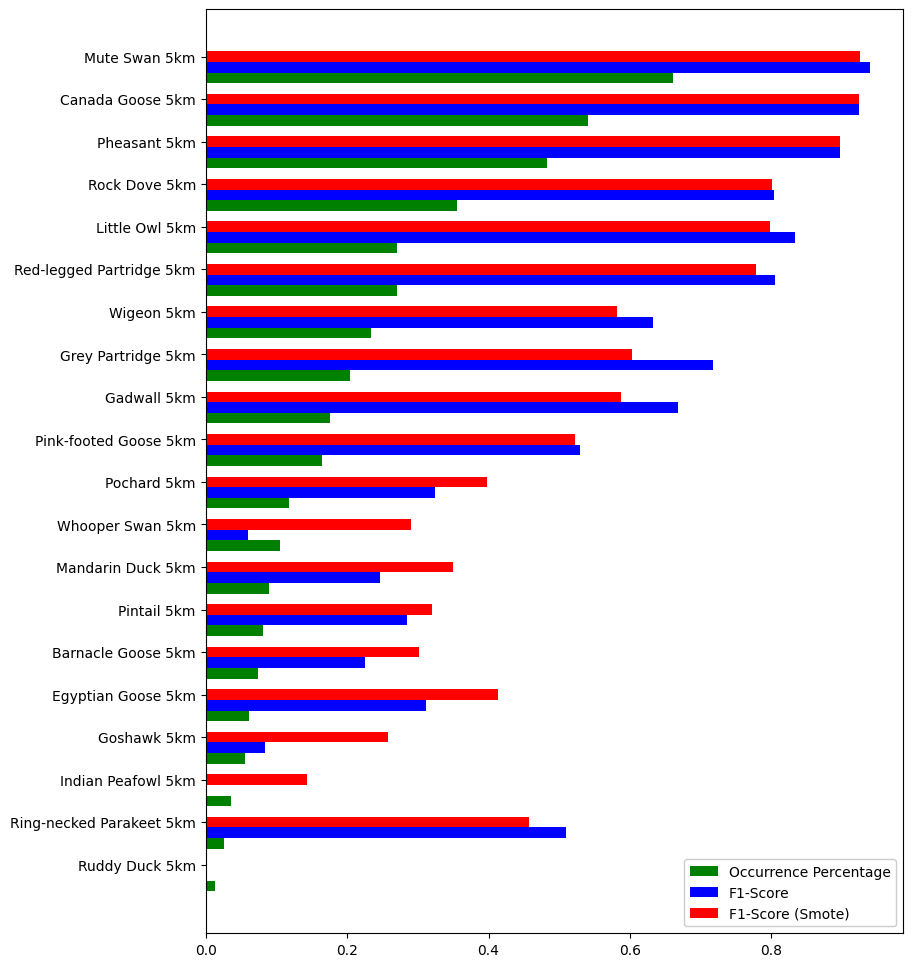

,Labels,Precision,Precision (Smote),Recall,Recall (Smote),F1,F1 (Smote),Occurrence Count,Percentage
9,Mute Swan 5km,0.916422,0.942400,0.963020,0.907550,0.939144,0.924647,5267,0.661268
1,Canada Goose 5km,0.888316,0.903111,0.961860,0.945116,0.923627,0.923636,4305,0.540490
10,Pheasant 5km,0.865179,0.859465,0.931106,0.938413,0.896933,0.897206,3848,0.483114
16,Rock Dove 5km,0.757812,0.754545,0.854626,0.853157,0.803313,0.800827,2830,0.355304
7,Little Owl 5km,0.751975,0.750433,0.935167,0.850688,0.833625,0.797422,2158,0.270935
14,Red-legged Partridge 5km,0.743377,0.735192,0.878669,0.825832,0.805381,0.777880,2150,0.269931
19,Wigeon 5km,0.623404,0.576017,0.641138,0.588621,0.632147,0.582251,1857,0.233145
5,Grey Partridge 5km,0.663793,0.622642,0.779747,0.584810,0.717113,0.603133,1629,0.204520
3,Gadwall 5km,0.664804,0.623418,0.670423,0.554930,0.667602,0.587183,1399,0.175643
11,Pink-footed Goose 5km,0.593750,0.477922,0.476489,0.576803,0.528696,0.522727,1313,0.164846


In [13]:
# Create graphs to show off data
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 12]

occurrence_count, occurrence_percentage = All_bird_occurrences['Occurrence Count'], All_bird_occurrences['Percentage']
precision = []
precision_smote = []
recall = []
recall_smote = []
f1 = []
f1_smote = []
labels = []
for dict in df_dicts:
    precision.append(dict['report']['1']['precision'])
    precision_smote.append(dict['report_smote']['1']['precision'])
    recall.append(dict['report']['1']['recall'])
    recall_smote.append(dict['report_smote']['1']['recall'])
    f1.append(dict['report']['1']['f1-score'])
    f1_smote.append(dict['report_smote']['1']['f1-score'])
    labels.append(dict['name'])



scores = pd.DataFrame({'Labels' : labels, 
                        'Precision': precision, 'Precision (Smote)': precision_smote, 
                        'Recall': recall, 'Recall (Smote)': recall_smote, 
                        'F1': f1, 'F1 (Smote)': f1_smote,
                        'Occurrence Count' : occurrence_count, 'Percentage' : occurrence_percentage} )
                        
scores.sort_values('Occurrence Count', inplace=True)

n=20
r = np.arange(n)
height = 0.25

plt.barh(r, 'Percentage', data=scores, label='Occurrence Percentage', height = height, color='g')
plt.barh(r+height, 'F1', data=scores, label='F1-Score',  height= height, color='b')
plt.barh(r+height*2, 'F1 (Smote)', data=scores, label='F1-Score (Smote)',  height = height, color='r')
plt.legend(framealpha=1, frameon=True)
plt.yticks(r+height*2, scores['Labels'])


plt.show()


scores.sort_values('Occurrence Count', ascending=False)

In [16]:
# Store dictionaries for later use
df_dicts_5km_no_fp = df_dicts
%store df_dicts_5km_no_fp

Stored 'df_dicts_5km_no_fp' (list)


In [15]:
# Export predictions to CSV for QGIS
RESULTS_PATH = 'Datasets/Machine Learning/Results/5km/'
for dict in df_dicts:
    # Join with y_test datafram
    result_df = dict['y_test'] 
    result_df['Predictions'] = dict['predictions_smote']
    display(result_df)
    result_df.to_csv(RESULTS_PATH + dict['name'] + '(without Fertiliser+Pesticides).csv')
    

Occurrence  Predictions
y         x                                
842500.0  367500.0           0            0
22500.0   197500.0           0            1
          27500.0            0            0
247500.0  252500.0           0            0
737500.0  62500.0            0            0
...                        ...          ...
862500.0  567500.0           0            0
152500.0  232500.0           0            0
1252500.0 592500.0           0            0
1002500.0 322500.0           0            0
192500.0  167500.0           0            0

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
572500.0,282500.0,1,1
32500.0,162500.0,1,1
37500.0,667500.0,0,0
182500.0,367500.0,1,1
477500.0,332500.0,1,1
...,...,...,...
592500.0,122500.0,0,0
132500.0,482500.0,1,1
1207500.0,432500.0,0,0


Occurrence  Predictions
y         x                                
827500.0  27500.0            0            0
22500.0   392500.0           0            0
          262500.0           0            0
212500.0  317500.0           0            0
727500.0  312500.0           0            0
...                        ...          ...
847500.0  82500.0            0            0
142500.0  512500.0           1            0
1252500.0 512500.0           0            0
1002500.0 337500.0           0            0
167500.0  17500.0            0            0

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
787500.0,87500.0,0,0
22500.0,2500.0,0,0
27500.0,562500.0,0,0
217500.0,457500.0,1,1
682500.0,387500.0,0,0
...,...,...,...
812500.0,382500.0,0,0
142500.0,342500.0,1,0
1242500.0,372500.0,0,0


Occurrence  Predictions
y         x                                
822500.0  422500.0           0            0
22500.0   647500.0           0            0
          547500.0           0            0
232500.0  392500.0           0            0
727500.0  507500.0           0            0
...                        ...          ...
837500.0  62500.0            0            0
142500.0  447500.0           0            0
1247500.0 517500.0           0            0
987500.0  287500.0           0            0
182500.0  672500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
767500.0  547500.0           0            0
27500.0   627500.0           0            0
          507500.0           0            0
222500.0  412500.0           0            0
662500.0  517500.0           0            0
...                        ...          ...
787500.0  567500.0           0            0
147500.0  522500.0           1            0
1242500.0 92500.0            0            0
957500.0  387500.0           0            0
177500.0  557500.0           1            0

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
827500.0,87500.0,0,0
22500.0,47500.0,0,0
27500.0,567500.0,0,0
227500.0,152500.0,0,0
732500.0,562500.0,0,0
...,...,...,...
852500.0,692500.0,0,0
142500.0,577500.0,0,1
1252500.0,597500.0,0,0


Occurrence  Predictions
y         x                                
722500.0  412500.0           0            0
27500.0   267500.0           0            0
          62500.0            0            0
197500.0  97500.0            0            0
602500.0  512500.0           0            0
...                        ...          ...
747500.0  412500.0           0            0
137500.0  152500.0           0            0
1242500.0 692500.0           0            0
932500.0  162500.0           0            0
162500.0  537500.0           1            1

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
822500.0  92500.0            0            0
22500.0   217500.0           0            0
          137500.0           0            0
212500.0  292500.0           0            0
717500.0  197500.0           0            0
...                        ...          ...
842500.0  372500.0           0            0
137500.0  392500.0           1            0
1247500.0 87500.0            0            0
997500.0  362500.0           0            0
172500.0  532500.0           0            1

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
582500.0  287500.0           1            1
42500.0   192500.0           0            1
          72500.0            0            0
192500.0  557500.0           1            1
487500.0  317500.0           1            1
...                        ...          ...
607500.0  422500.0           1            1
137500.0  302500.0           1            1
1192500.0 637500.0           0            0
737500.0  417500.0           0            0
162500.0  482500.0           1            1

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
642500.0,327500.0,1,1
32500.0,142500.0,0,1
37500.0,577500.0,0,0
192500.0,352500.0,1,1
537500.0,87500.0,1,0
...,...,...,...
662500.0,347500.0,0,1
137500.0,512500.0,1,1
1217500.0,402500.0,0,0


,,Occurrence,Predictions
y,x,,
817500.0,352500.0,1,1
22500.0,37500.0,0,0
27500.0,642500.0,0,0
272500.0,297500.0,0,1
722500.0,327500.0,1,1
...,...,...,...
837500.0,372500.0,1,1
162500.0,67500.0,0,0
1242500.0,212500.0,0,0


Occurrence  Predictions
y         x                                
837500.0  152500.0           0            1
22500.0   367500.0           0            0
          222500.0           0            0
237500.0  217500.0           0            0
722500.0  332500.0           1            0
...                        ...          ...
857500.0  267500.0           1            0
147500.0  287500.0           1            0
1252500.0 152500.0           0            0
1012500.0 92500.0            0            0
187500.0  572500.0           0            1

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
807500.0,247500.0,0,0
17500.0,27500.0,0,0
22500.0,507500.0,0,0
222500.0,32500.0,0,0
707500.0,677500.0,0,0
...,...,...,...
827500.0,362500.0,0,0
142500.0,302500.0,0,1
1242500.0,242500.0,0,0


Occurrence  Predictions
y         x                                
747500.0  162500.0           0            0
32500.0   612500.0           0            0
          482500.0           0            0
207500.0  202500.0           0            0
627500.0  272500.0           0            0
...                        ...          ...
772500.0  292500.0           0            1
142500.0  532500.0           1            1
1242500.0 452500.0           0            0
937500.0  542500.0           0            0
167500.0  307500.0           0            1

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
857500.0  647500.0           0            0
22500.0   632500.0           0            0
          562500.0           0            0
227500.0  442500.0           0            0
752500.0  517500.0           0            0
...                        ...          ...
872500.0  267500.0           0            0
147500.0  322500.0           0            0
1252500.0 547500.0           0            0
1017500.0 362500.0           0            0
177500.0  37500.0            0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
712500.0  332500.0           1            1
27500.0   437500.0           0            0
          137500.0           0            1
197500.0  447500.0           1            1
607500.0  247500.0           0            0
...                        ...          ...
732500.0  332500.0           0            1
142500.0  692500.0           0            0
1232500.0 552500.0           0            0
902500.0  302500.0           0            0
167500.0  562500.0           1            1

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
857500.0  512500.0           0            0
22500.0   587500.0           0            0
          447500.0           0            0
237500.0  512500.0           0            0
752500.0  77500.0            0            0
...                        ...          ...
872500.0  512500.0           0            0
142500.0  167500.0           0            0
1252500.0 422500.0           0            0
1007500.0 72500.0            0            0
182500.0  142500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
847500.0  507500.0           0            0
27500.0   597500.0           0            0
          472500.0           0            0
267500.0  387500.0           0            0
742500.0  197500.0           0            0
...                        ...          ...
862500.0  607500.0           0            0
162500.0  447500.0           0            0
1247500.0 87500.0            0            0
1002500.0 462500.0           0            0
202500.0  237500.0           0            1

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
787500.0  97500.0            0            0
27500.0   167500.0           0            1
          107500.0           0            0
232500.0  602500.0           1            1
687500.0  72500.0            0            0
...                        ...          ...
807500.0  192500.0           1            1
147500.0  602500.0           0            1
1237500.0 332500.0           0            0
957500.0  122500.0           0            0
182500.0  582500.0           1            0

[1992 rows x 2 columns]

In [ ]:
for dict in df_dicts:
    print(dict['name'])
    display(dict['kbest']['Dataframe'])

Barnacle Goose 1km


,F Score,P Value,Attribute
25,1586.660696,0.000000e+00,Inflowing drainage direction
18,1440.939379,1.143607e-308,Saltmarsh
23,1417.879628,7.271005e-304,Surface type
22,1269.611405,6.667737e-273,Cumulative catchment area
24,1223.198053,3.502336e-263,Outflowing drainage direction
21,1203.742558,4.196966e-259,Elevation
17,1078.608288,8.174358e-233,Littoral sediment
13,978.472706,1.050650e-211,Freshwater
15,853.811730,2.457887e-185,Supralittoral sediment
3,816.914586,1.639367e-177,Improve grassland


Canada Goose 1km


,F Score,P Value,Attribute
23,27980.651957,0.000000e+00,Surface type
24,22192.853532,0.000000e+00,Outflowing drainage direction
25,21798.073867,0.000000e+00,Inflowing drainage direction
21,20557.269520,0.000000e+00,Elevation
22,10467.973712,0.000000e+00,Cumulative catchment area
3,9373.992389,0.000000e+00,Improve grassland
20,6200.682674,0.000000e+00,Suburban
0,4606.437967,0.000000e+00,Deciduous woodland
2,4435.557422,0.000000e+00,Arable
19,2407.892997,0.000000e+00,Urban


Egyptian Goose 1km


,F Score,P Value,Attribute
22,4398.345684,0.000000e+00,Cumulative catchment area
13,3391.728526,0.000000e+00,Freshwater
24,2769.983626,0.000000e+00,Outflowing drainage direction
19,2688.563744,0.000000e+00,Urban
23,2448.189595,0.000000e+00,Surface type
25,1867.181758,0.000000e+00,Inflowing drainage direction
20,1608.119655,0.000000e+00,Suburban
21,1508.446202,1.037538e-322,Elevation
3,1160.254219,5.600729e-250,Improve grassland
0,1025.549798,1.228685e-221,Deciduous woodland


Gadwall 1km


,F Score,P Value,Attribute
24,5605.884628,0.000000e+00,Outflowing drainage direction
22,5421.221412,0.000000e+00,Cumulative catchment area
23,5337.742415,0.000000e+00,Surface type
25,4250.868883,0.000000e+00,Inflowing drainage direction
13,3657.950458,0.000000e+00,Freshwater
21,3513.520144,0.000000e+00,Elevation
2,2555.774940,0.000000e+00,Arable
3,2162.540101,0.000000e+00,Improve grassland
20,1871.462238,0.000000e+00,Suburban
0,1487.487019,2.357158e-318,Deciduous woodland


Goshawk 1km


,F Score,P Value,Attribute
23,1228.008833,3.437230e-264,Surface type
21,1131.658994,5.687958e-244,Elevation
24,1068.037277,1.373575e-230,Outflowing drainage direction
22,1044.933301,1.009602e-225,Cumulative catchment area
25,919.889067,2.517246e-199,Inflowing drainage direction
0,809.818171,5.254241e-176,Deciduous woodland
3,684.780108,2.032079e-149,Improve grassland
1,397.809147,5.441281e-88,Coniferous woodland
6,362.459808,2.209967e-80,Acid grassland
2,87.757391,7.852555e-21,Arable


Grey Partridge 1km


,F Score,P Value,Attribute
2,8141.700589,0.000000e+00,Arable
23,5901.470556,0.000000e+00,Surface type
24,4800.409421,0.000000e+00,Outflowing drainage direction
22,4601.906150,0.000000e+00,Cumulative catchment area
25,4463.973740,0.000000e+00,Inflowing drainage direction
21,4389.262340,0.000000e+00,Elevation
3,2126.495399,0.000000e+00,Improve grassland
0,901.238763,2.221379e-195,Deciduous woodland
20,518.009891,8.599298e-114,Suburban
5,327.045266,9.488789e-73,Calcareous grassland


Indian Peafowl 1km


,F Score,P Value,Attribute
23,826.341713,1.639780e-179,Surface type
22,773.116357,3.264405e-168,Cumulative catchment area
24,694.651908,1.603430e-151,Outflowing drainage direction
2,636.396656,4.208646e-139,Arable
25,618.098698,3.386540e-135,Inflowing drainage direction
21,581.270648,2.497700e-127,Elevation
3,579.289817,6.621914e-127,Improve grassland
0,557.985251,2.382356e-122,Deciduous woodland
20,341.361921,7.768283e-76,Suburban
4,31.037453,2.550632e-08,Neutral grassland


Little Owl 1km


,F Score,P Value,Attribute
23,9941.994917,0.000000e+00,Surface type
2,9462.794504,0.000000e+00,Arable
24,8442.661824,0.000000e+00,Outflowing drainage direction
22,7788.899641,0.000000e+00,Cumulative catchment area
25,7508.970331,0.000000e+00,Inflowing drainage direction
21,6742.553493,0.000000e+00,Elevation
3,4944.473615,0.000000e+00,Improve grassland
20,2250.993774,0.000000e+00,Suburban
0,1224.086080,2.281664e-263,Deciduous woodland
4,630.020519,9.656906e-138,Neutral grassland


Mandarin Duck 1km


,F Score,P Value,Attribute
22,3559.780952,0.000000e+00,Cumulative catchment area
0,3525.975295,0.000000e+00,Deciduous woodland
24,2973.634105,0.000000e+00,Outflowing drainage direction
23,2900.268149,0.000000e+00,Surface type
3,2556.207049,0.000000e+00,Improve grassland
25,2139.256963,0.000000e+00,Inflowing drainage direction
21,2040.599063,0.000000e+00,Elevation
20,1659.981195,0.000000e+00,Suburban
13,792.705495,2.254877e-172,Freshwater
19,434.160164,8.347169e-96,Urban


Mute Swan 1km


,F Score,P Value,Attribute
23,41778.683149,0.000000e+00,Surface type
25,37707.864005,0.000000e+00,Inflowing drainage direction
21,32149.803935,0.000000e+00,Elevation
24,24629.730532,0.000000e+00,Outflowing drainage direction
22,7714.991172,0.000000e+00,Cumulative catchment area
3,6922.429433,0.000000e+00,Improve grassland
20,5556.769597,0.000000e+00,Suburban
2,4548.309043,0.000000e+00,Arable
0,3188.833827,0.000000e+00,Deciduous woodland
19,2126.916337,0.000000e+00,Urban


Pheasant 1km


,F Score,P Value,Attribute
23,14828.439300,0.000000e+00,Surface type
24,12411.664397,0.000000e+00,Outflowing drainage direction
21,11511.436305,0.000000e+00,Elevation
25,11025.748971,0.000000e+00,Inflowing drainage direction
22,9363.861895,0.000000e+00,Cumulative catchment area
3,6889.758402,0.000000e+00,Improve grassland
2,5020.115469,0.000000e+00,Arable
0,3497.652887,0.000000e+00,Deciduous woodland
20,1872.691498,0.000000e+00,Suburban
5,415.858475,7.152889e-92,Calcareous grassland


Pink-footed Goose 1km


,F Score,P Value,Attribute
25,5823.246006,0.000000e+00,Inflowing drainage direction
23,5796.329675,0.000000e+00,Surface type
21,4750.062797,0.000000e+00,Elevation
24,4416.411546,0.000000e+00,Outflowing drainage direction
22,4111.240745,0.000000e+00,Cumulative catchment area
2,4027.385455,0.000000e+00,Arable
17,1680.756257,0.000000e+00,Littoral sediment
3,1578.759585,0.000000e+00,Improve grassland
18,1503.642898,1.032597e-321,Saltmarsh
20,1109.115857,3.118895e-239,Suburban


Pintail 1km


,F Score,P Value,Attribute
25,1325.168183,1.608067e-284,Inflowing drainage direction
23,1169.840995,5.439990e-252,Surface type
21,987.248175,1.475675e-213,Elevation
24,832.260391,9.109264e-181,Outflowing drainage direction
18,829.398253,3.685447e-180,Saltmarsh
22,760.526243,1.546155e-165,Cumulative catchment area
2,723.168873,1.361610e-157,Arable
17,700.432781,9.417029e-153,Littoral sediment
3,435.362823,4.604501e-96,Improve grassland
20,333.610377,3.643021e-74,Suburban


Pochard 1km


,F Score,P Value,Attribute
23,1842.761284,0.000000e+00,Surface type
2,1555.536108,0.000000e+00,Arable
25,1549.051565,0.000000e+00,Inflowing drainage direction
24,1485.853766,5.152527e-318,Outflowing drainage direction
22,1392.732967,1.268634e-298,Cumulative catchment area
21,1309.187405,3.516732e-281,Elevation
20,894.234195,6.746925e-194,Suburban
3,745.160492,2.857352e-162,Improve grassland
19,743.681811,5.893993e-162,Urban
0,574.470893,7.099727e-126,Deciduous woodland


Red-legged Partridge 1km


,F Score,P Value,Attribute
2,9262.561980,0.000000e+00,Arable
23,8310.347324,0.000000e+00,Surface type
24,6580.468060,0.000000e+00,Outflowing drainage direction
25,6132.393216,0.000000e+00,Inflowing drainage direction
21,6122.856668,0.000000e+00,Elevation
22,6094.072173,0.000000e+00,Cumulative catchment area
3,3761.382336,0.000000e+00,Improve grassland
0,1821.322033,0.000000e+00,Deciduous woodland
20,591.420483,1.691353e-129,Suburban
5,325.757650,1.798558e-72,Calcareous grassland


Ring-necked Parakeet 1km


,F Score,P Value,Attribute
20,5174.029480,0.000000e+00,Suburban
19,4816.293327,0.000000e+00,Urban
22,2110.055997,0.000000e+00,Cumulative catchment area
23,1451.182004,8.429407e-311,Surface type
24,1239.102083,1.629495e-266,Outflowing drainage direction
25,1101.552188,1.215523e-237,Inflowing drainage direction
21,934.465809,2.082605e-202,Elevation
0,644.695315,7.138206e-141,Deciduous woodland
3,590.530935,2.620156e-129,Improve grassland
13,266.908247,9.184502e-60,Freshwater


Rock Dove 1km


,F Score,P Value,Attribute
23,9715.208896,0.000000e+00,Surface type
24,7716.649425,0.000000e+00,Outflowing drainage direction
25,7489.623513,0.000000e+00,Inflowing drainage direction
21,7209.182719,0.000000e+00,Elevation
22,6950.626400,0.000000e+00,Cumulative catchment area
3,4736.971375,0.000000e+00,Improve grassland
20,4361.914241,0.000000e+00,Suburban
2,3272.566853,0.000000e+00,Arable
0,1947.276915,0.000000e+00,Deciduous woodland
19,1698.722674,0.000000e+00,Urban


Ruddy Duck 1km


,F Score,P Value,Attribute
13,2084.023887,0.000000e+00,Freshwater
24,574.800456,6.036397e-126,Outflowing drainage direction
22,439.953763,4.753911e-97,Cumulative catchment area
23,331.644948,9.666367e-74,Surface type
25,252.505585,1.196889e-56,Inflowing drainage direction
19,209.791045,2.131385e-47,Urban
21,206.348108,1.188914e-46,Elevation
0,197.545829,9.644094e-45,Deciduous woodland
4,178.469812,1.333079e-40,Neutral grassland
3,159.658114,1.632226e-36,Improve grassland


Whooper Swan 1km


,F Score,P Value,Attribute
25,1676.560528,0.000000e+00,Inflowing drainage direction
23,1555.884294,0.000000e+00,Surface type
21,1411.884325,1.291051e-302,Elevation
24,1295.050837,3.175931e-278,Outflowing drainage direction
22,1252.169594,2.987125e-269,Cumulative catchment area
3,560.870223,5.752589e-123,Improve grassland
2,518.099739,8.226528e-114,Arable
13,302.457075,1.918026e-67,Freshwater
17,294.097064,1.224555e-65,Littoral sediment
0,236.168141,4.111276e-53,Deciduous woodland


Wigeon 1km


,F Score,P Value,Attribute
25,4543.858943,0.000000e+00,Inflowing drainage direction
23,4385.352401,0.000000e+00,Surface type
21,3772.569210,0.000000e+00,Elevation
24,3296.213107,0.000000e+00,Outflowing drainage direction
22,3018.447019,0.000000e+00,Cumulative catchment area
3,1984.684092,0.000000e+00,Improve grassland
2,1640.404091,0.000000e+00,Arable
0,1016.533733,9.783489e-220,Deciduous woodland
20,871.988879,3.462062e-189,Suburban
17,839.439277,2.736586e-182,Littoral sediment
